In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(32, activation='relu'))
        
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 1029.9397 - mae: 7.4817 - mape: 478.8540 - student_loss: 7.4584 - distillation_loss: 1024.7390 - val_mse: 14.7125 - val_mae: 2.6582 - val_mape: 167.9587 - val_student_loss: 1.9583
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.6290 - mae: 0.8857 - mape: 60.5304 - student_loss: 0.8857 - distillation_loss: 2.1214 - val_mse: 1.0160 - val_mae: 0.6575 - val_mape: 41.8479 - val_student_loss: 0.8463
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9297 - mae: 0.6565 - mape: 44.7397 - student_loss: 0.6558 - distillation_loss: 0.4883 - val_mse: 0.5809 - val_mae: 0.6010 - val_mape: 44.0192 - val_student_loss: 0.7088
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6248 - mae: 0.5885 - mape: 38.7131 - student_loss: 0.5879 - distillation_loss: 0.1975 - val_mse: 0.7820 - val_mae: 0.6963 - val_mape: 52.1490 - val_student_loss: 0.7244
Epoc

443/443 [==============================] - 1s 2ms/step - mse: 0.6626 - mae: 0.5805 - mape: 37.0822 - student_loss: 0.5795 - distillation_loss: 0.2467 - val_mse: 0.6773 - val_mae: 0.5536 - val_mape: 37.3730 - val_student_loss: 0.6768
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8811 - mae: 0.6365 - mape: 40.7729 - student_loss: 0.6360 - distillation_loss: 0.4696 - val_mse: 0.9088 - val_mae: 0.7781 - val_mape: 59.1748 - val_student_loss: 0.9415
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9228 - mae: 0.6826 - mape: 43.6346 - student_loss: 0.6832 - distillation_loss: 0.4929 - val_mse: 2.5194 - val_mae: 1.2607 - val_mape: 96.0424 - val_student_loss: 1.2140
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 37.1162 - mae: 2.1754 - mape: 145.4593 - student_loss: 2.1686 - distillation_loss: 36.5021 - val_mse: 0.6428 - val_mae: 0.6238 - val_mape: 46.0411 - val_student_loss: 0.7797
Epoch 38/100
443/443 [====

443/443 [==============================] - 1s 2ms/step - mse: 2.4964 - mae: 0.9143 - mape: 59.9216 - student_loss: 0.9119 - distillation_loss: 2.0672 - val_mse: 0.4909 - val_mae: 0.5389 - val_mape: 37.8923 - val_student_loss: 0.6607
Epoch 68/100
443/443 [==============================] - 1s 3ms/step - mse: 0.6740 - mae: 0.5989 - mape: 38.7334 - student_loss: 0.5975 - distillation_loss: 0.2715 - val_mse: 0.5158 - val_mae: 0.5072 - val_mape: 32.6407 - val_student_loss: 0.5931
Epoch 69/100
443/443 [==============================] - 1s 3ms/step - mse: 0.8551 - mae: 0.6423 - mape: 41.3002 - student_loss: 0.6414 - distillation_loss: 0.4479 - val_mse: 0.4796 - val_mae: 0.5207 - val_mape: 35.6883 - val_student_loss: 0.6532
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 11.8588 - mae: 1.4048 - mape: 92.3935 - student_loss: 1.4032 - distillation_loss: 11.3328 - val_mse: 0.5570 - val_mae: 0.5595 - val_mape: 39.9975 - val_student_loss: 0.7085
Epoch 71/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 1.4105 - mae: 0.7167 - mape: 46.6665 - student_loss: 0.7157 - distillation_loss: 0.9916 - val_mse: 0.5338 - val_mae: 0.5386 - val_mape: 30.7297 - val_student_loss: 0.6478
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 3.7540 - mse: 64.0315 - mae: 3.7540 - mape: 251.2358 - val_loss: 5.5407 - val_mse: 50.1317 - val_mae: 5.5407 - val_mape: 405.3860
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 2.5377 - mse: 15.0609 - mae: 2.5377 - mape: 169.6113 - val_loss: 2.7449 - val_mse: 12.8038 - val_mae: 2.7449 - val_mape: 210.3107
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 2.3623 - mse: 13.2274 - mae: 2.3623 - mape: 157.1189 - val_loss: 4.3457 - val_mse: 30.1253 - val_mae: 4.3457 - val_mape: 273.1501
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.8071 - mse: 7.7183 - mae: 1.8071 - mape: 119.1431 - val_loss: 5.0787 - val_

443/443 [==============================] - 1s 2ms/step - loss: 1.1033 - mse: 2.7534 - mae: 1.1033 - mape: 71.5449 - val_loss: 3.2173 - val_mse: 16.6178 - val_mae: 3.2173 - val_mape: 233.4652
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9391 - mse: 2.0346 - mae: 0.9391 - mape: 60.4668 - val_loss: 0.5157 - val_mse: 0.4642 - val_mae: 0.5157 - val_mape: 33.2703
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9159 - mse: 1.8897 - mae: 0.9159 - mape: 58.3023 - val_loss: 1.1821 - val_mse: 2.1900 - val_mae: 1.1821 - val_mape: 90.0937
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1072 - mse: 2.5193 - mae: 1.1072 - mape: 72.0805 - val_loss: 1.6667 - val_mse: 4.5233 - val_mae: 1.6667 - val_mape: 125.3079
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9519 - mse: 1.9130 - mae: 0.9519 - mape: 61.1186 - val_loss: 0.5157 - val_mse: 0.5397 - val_mae: 0.5157 - val_mape: 33.0898


Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5892 - mse: 0.6608 - mae: 0.5892 - mape: 36.5756 - val_loss: 0.5168 - val_mse: 0.5087 - val_mae: 0.5168 - val_mape: 28.6018
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5744 - mse: 0.6032 - mae: 0.5744 - mape: 35.7059 - val_loss: 0.5159 - val_mse: 0.4460 - val_mae: 0.5159 - val_mape: 35.6648
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6025 - mse: 0.6526 - mae: 0.6025 - mape: 37.6877 - val_loss: 0.6494 - val_mse: 0.7453 - val_mae: 0.6494 - val_mape: 33.6678
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5640 - mse: 0.5712 - mae: 0.5640 - mape: 34.8987 - val_loss: 0.5561 - val_mse: 0.4967 - val_mae: 0.5561 - val_mape: 40.7026
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5844 - mse: 0.6230 - mae: 0.5844 - mape: 36.1516 - val_loss: 0.7632 - val_mse: 0.9711 - val_mae: 0.7632 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8932 - mae: 0.8655 - mape: 56.4857 - student_loss: 0.8655 - distillation_loss: 1.4649 - val_mse: 0.5476 - val_mae: 0.5955 - val_mape: 42.2729 - val_student_loss: 0.5518
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 3.3249 - mae: 1.0298 - mape: 66.7104 - student_loss: 1.0300 - distillation_loss: 2.8821 - val_mse: 2.3755 - val_mae: 1.1367 - val_mape: 59.8448 - val_student_loss: 0.4305
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2563 - mae: 0.7470 - mape: 48.9941 - student_loss: 0.7467 - distillation_loss: 0.8287 - val_mse: 0.4957 - val_mae: 0.5414 - val_mape: 35.5170 - val_student_loss: 0.4493
Epoch 21/100
443/443 [==============================] - 1s 3ms/step - mse: 4.2686 - mae: 1.2065 - mape: 79.6698 - student_loss: 1.2054 - distillation_loss: 3.8376 - val_mse: 2.2885 - val_mae: 1.1195 - val_mape: 58.8542 - val_student_loss: 0.3569
Epoch 22/100
443

443/443 [==============================] - 1s 3ms/step - mse: 1.1036 - mae: 0.6596 - mape: 43.0362 - student_loss: 0.6591 - distillation_loss: 0.6786 - val_mse: 0.5767 - val_mae: 0.5790 - val_mape: 36.6311 - val_student_loss: 0.4684
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8426 - mae: 0.6974 - mape: 45.6014 - student_loss: 0.7127 - distillation_loss: 1.4982 - val_mse: 7.2699 - val_mae: 1.7926 - val_mape: 129.9121 - val_student_loss: 1.6164
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2114 - mae: 0.7241 - mape: 47.1424 - student_loss: 0.7230 - distillation_loss: 0.7898 - val_mse: 0.5150 - val_mae: 0.5520 - val_mape: 35.7762 - val_student_loss: 0.4438
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5715 - mae: 0.5770 - mape: 37.4931 - student_loss: 0.5768 - distillation_loss: 0.1469 - val_mse: 0.8747 - val_mae: 0.7446 - val_mape: 55.2520 - val_student_loss: 0.8007
Epoch 55/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.5246 - mae: 0.5407 - mape: 35.2055 - student_loss: 0.5409 - distillation_loss: 0.1225 - val_mse: 0.5578 - val_mae: 0.5443 - val_mape: 29.8814 - val_student_loss: 0.2112
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4583 - mae: 0.5076 - mape: 33.0376 - student_loss: 0.5073 - distillation_loss: 0.0597 - val_mse: 0.4022 - val_mae: 0.4819 - val_mape: 30.9196 - val_student_loss: 0.3093
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7156 - mae: 0.5658 - mape: 37.6094 - student_loss: 0.5654 - distillation_loss: 0.3192 - val_mse: 0.4174 - val_mae: 0.4992 - val_mape: 33.7398 - val_student_loss: 0.3392
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4458 - mae: 0.5014 - mape: 32.7364 - student_loss: 0.5016 - distillation_loss: 0.0493 - val_mse: 0.4224 - val_mae: 0.4854 - val_mape: 29.9244 - val_student_loss: 0.2570
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5335 - mse: 5.7694 - mae: 1.5335 - mape: 101.7195 - val_loss: 1.8279 - val_mse: 6.5227 - val_mae: 1.8279 - val_mape: 131.7871
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4827 - mse: 5.6646 - mae: 1.4827 - mape: 98.3143 - val_loss: 0.5392 - val_mse: 0.5354 - val_mae: 0.5392 - val_mape: 30.8256
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2980 - mse: 3.9655 - mae: 1.2980 - mape: 84.8189 - val_loss: 0.6382 - val_mse: 0.7612 - val_mae: 0.6382 - val_mape: 32.9861
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4148 - mse: 4.8654 - mae: 1.4148 - mape: 93.9833 - val_loss: 1.5517 - val_mse: 4.7408 - val_mae: 1.5517 - val_mape: 87.5635
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4706 - mse: 5.0117 - mae: 1.4706 - mape: 97.3401 - val_loss: 0.8527 - val_mse: 1.5160 - val_mae: 0.8527 - val_ma

443/443 [==============================] - 1s 2ms/step - loss: 0.8749 - mse: 1.4738 - mae: 0.8749 - mape: 56.2462 - val_loss: 0.5387 - val_mse: 0.5089 - val_mae: 0.5387 - val_mape: 36.0175
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7799 - mse: 1.3050 - mae: 0.7799 - mape: 50.0534 - val_loss: 1.1045 - val_mse: 2.1640 - val_mae: 1.1045 - val_mape: 59.4487
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7096 - mse: 1.0805 - mae: 0.7096 - mape: 44.9132 - val_loss: 0.9043 - val_mse: 1.4873 - val_mae: 0.9043 - val_mape: 66.5318
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7899 - mse: 1.4604 - mae: 0.7899 - mape: 50.8135 - val_loss: 0.5888 - val_mse: 0.6245 - val_mae: 0.5888 - val_mape: 37.8826
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7770 - mse: 1.2491 - mae: 0.7770 - mape: 49.7630 - val_loss: 0.5210 - val_mse: 0.4914 - val_mae: 0.5210 - val_mape: 33.1491
Epo

443/443 [==============================] - 1s 3ms/step - mse: 231.9681 - mae: 4.1631 - mape: 269.9344 - student_loss: 4.1480 - distillation_loss: 230.3122 - val_mse: 2.0933 - val_mae: 1.0974 - val_mape: 56.8831 - val_student_loss: 0.9018
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.8216 - mae: 1.0415 - mape: 68.1691 - student_loss: 1.0396 - distillation_loss: 2.3726 - val_mse: 1.3676 - val_mae: 0.9554 - val_mape: 71.6533 - val_student_loss: 0.8793
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - mse: 1.8902 - mae: 0.9509 - mape: 66.1061 - student_loss: 0.9501 - distillation_loss: 1.4398 - val_mse: 1.2388 - val_mae: 0.8880 - val_mape: 60.2482 - val_student_loss: 0.8591
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - mse: 1.4755 - mae: 0.9187 - mape: 64.4020 - student_loss: 0.9192 - distillation_loss: 1.0197 - val_mse: 1.2660 - val_mae: 0.9373 - val_mape: 75.0908 - val_student_loss: 0.8000
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.5357 - mae: 0.5553 - mape: 35.9634 - student_loss: 0.5562 - distillation_loss: 0.1170 - val_mse: 1.6019 - val_mae: 0.9430 - val_mape: 51.7785 - val_student_loss: 0.6471
Epoch 35/100
443/443 [==============================] - 1s 3ms/step - mse: 2.5663 - mae: 0.8121 - mape: 52.9790 - student_loss: 0.8119 - distillation_loss: 2.1554 - val_mse: 0.5082 - val_mae: 0.5550 - val_mape: 38.3806 - val_student_loss: 0.5231
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5055 - mae: 0.5420 - mape: 34.9739 - student_loss: 0.5426 - distillation_loss: 0.0947 - val_mse: 0.5028 - val_mae: 0.5507 - val_mape: 37.5337 - val_student_loss: 0.5620
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6056 - mae: 0.5765 - mape: 36.8396 - student_loss: 0.5761 - distillation_loss: 0.1976 - val_mse: 0.5766 - val_mae: 0.5513 - val_mape: 31.2524 - val_student_loss: 0.5118
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4966 - mae: 0.5292 - mape: 34.1109 - student_loss: 0.5310 - distillation_loss: 0.1061 - val_mse: 0.5679 - val_mae: 0.6022 - val_mape: 44.0677 - val_student_loss: 0.5141
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4886 - mae: 0.5274 - mape: 33.8702 - student_loss: 0.5271 - distillation_loss: 0.0931 - val_mse: 0.5223 - val_mae: 0.5797 - val_mape: 42.0460 - val_student_loss: 0.5199
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7181 - mae: 0.5918 - mape: 38.1069 - student_loss: 0.5908 - distillation_loss: 0.3300 - val_mse: 0.4937 - val_mae: 0.5122 - val_mape: 30.1924 - val_student_loss: 0.4852
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0427 - mae: 0.6213 - mape: 39.9938 - student_loss: 0.6238 - distillation_loss: 0.6548 - val_mse: 2.3667 - val_mae: 1.1365 - val_mape: 61.3441 - val_student_loss: 0.7219
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4514 - mae: 0.5056 - mape: 32.6435 - student_loss: 0.5057 - distillation_loss: 0.0606 - val_mse: 0.4147 - val_mae: 0.4827 - val_mape: 31.6565 - val_student_loss: 0.4358
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 2.5703 - mse: 34.5985 - mae: 2.5703 - mape: 176.5195 - val_loss: 2.6727 - val_mse: 11.0337 - val_mae: 2.6727 - val_mape: 208.8581
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4281 - mse: 5.0809 - mae: 1.4281 - mape: 95.4853 - val_loss: 2.8706 - val_mse: 13.6648 - val_mae: 2.8706 - val_mape: 169.2639
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6120 - mse: 5.7321 - mae: 1.6120 - mape: 108.0040 - val_loss: 1.2237 - val_mse: 2.5954 - val_mae: 1.2237 - val_mape: 65.5392
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5122 - mse: 5.8010 - mae: 1.5122 - mape: 100.0403 - val_loss: 0.5726 - val_mse: 

443/443 [==============================] - 1s 2ms/step - loss: 0.8444 - mse: 1.7198 - mae: 0.8444 - mape: 54.0598 - val_loss: 0.7990 - val_mse: 1.2004 - val_mae: 0.7990 - val_mape: 43.3775
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7583 - mse: 1.2651 - mae: 0.7583 - mape: 48.3274 - val_loss: 0.5809 - val_mse: 0.6362 - val_mae: 0.5809 - val_mape: 32.0414
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8368 - mse: 1.4709 - mae: 0.8368 - mape: 53.5733 - val_loss: 0.6880 - val_mse: 0.8562 - val_mae: 0.6880 - val_mape: 37.5628
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8711 - mse: 1.5228 - mae: 0.8711 - mape: 55.5808 - val_loss: 0.5721 - val_mse: 0.5358 - val_mae: 0.5721 - val_mape: 39.7474
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7711 - mse: 1.2234 - mae: 0.7711 - mape: 49.3954 - val_loss: 0.7015 - val_mse: 0.7583 - val_mae: 0.7015 - val_mape: 51.9789
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5732 - mse: 0.6121 - mae: 0.5732 - mape: 35.5775 - val_loss: 0.5722 - val_mse: 0.5199 - val_mae: 0.5722 - val_mape: 40.8795
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5639 - mse: 0.6080 - mae: 0.5639 - mape: 34.9291 - val_loss: 0.6939 - val_mse: 0.8185 - val_mae: 0.6939 - val_mape: 48.9919
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5844 - mse: 0.6800 - mae: 0.5844 - mape: 36.2773 - val_loss: 0.5026 - val_mse: 0.4552 - val_mae: 0.5026 - val_mape: 32.7218
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5493 - mse: 0.5751 - mae: 0.5493 - mape: 33.7093 - val_loss: 0.6798 - val_mse: 0.6829 - val_mae: 0.6798 - val_mape: 51.2091
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5761 - mse: 0.6515 - mae: 0.5761 - mape: 35.6414 - val_loss: 0.5466 - val_mse: 0.4848 - val_mae: 0.5466 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 3ms/step - mse: 0.7060 - mae: 0.6110 - mape: 40.2192 - student_loss: 0.6112 - distillation_loss: 0.2837 - val_mse: 1.2788 - val_mae: 0.8233 - val_mape: 44.0222 - val_student_loss: 0.3092
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8561 - mae: 0.6497 - mape: 42.3517 - student_loss: 0.6494 - distillation_loss: 0.4209 - val_mse: 0.5154 - val_mae: 0.5557 - val_mape: 38.1100 - val_student_loss: 0.4305
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 4.9516 - mae: 1.0737 - mape: 70.9657 - student_loss: 1.0721 - distillation_loss: 4.5462 - val_mse: 1.1081 - val_mae: 0.8448 - val_mape: 66.0896 - val_student_loss: 0.8432
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 53.8350 - mae: 2.0130 - mape: 130.4755 - student_loss: 2.0307 - distillation_loss: 53.5290 - val_mse: 218.4654 - val_mae: 10.7010 - val_mape: 704.1409 - val_student_loss: 6.7980
Epoch 22/

443/443 [==============================] - 1s 2ms/step - mse: 0.5222 - mae: 0.5408 - mape: 35.3943 - student_loss: 0.5396 - distillation_loss: 0.1016 - val_mse: 0.5460 - val_mae: 0.5388 - val_mape: 33.3099 - val_student_loss: 0.3093
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5634 - mae: 0.5609 - mape: 36.4935 - student_loss: 0.5600 - distillation_loss: 0.1441 - val_mse: 1.3416 - val_mae: 0.8453 - val_mape: 45.6170 - val_student_loss: 0.3729
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9449 - mae: 0.6745 - mape: 43.7735 - student_loss: 0.6733 - distillation_loss: 0.5185 - val_mse: 0.5156 - val_mae: 0.5604 - val_mape: 39.1960 - val_student_loss: 0.4771
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 1.5950 - mae: 0.7699 - mape: 49.6771 - student_loss: 0.7782 - distillation_loss: 1.2269 - val_mse: 20.2008 - val_mae: 3.5194 - val_mape: 255.1941 - val_student_loss: 2.8826
Epoch 55/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 2.3562 - mae: 0.9100 - mape: 59.0484 - student_loss: 0.9107 - distillation_loss: 1.9316 - val_mse: 0.6417 - val_mae: 0.5767 - val_mape: 31.5750 - val_student_loss: 0.2014
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6206 - mae: 0.5875 - mape: 38.5710 - student_loss: 0.5865 - distillation_loss: 0.2117 - val_mse: 0.5422 - val_mae: 0.5881 - val_mape: 42.2278 - val_student_loss: 0.5008
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5146 - mae: 0.5463 - mape: 35.3799 - student_loss: 0.5461 - distillation_loss: 0.1041 - val_mse: 0.5101 - val_mae: 0.5562 - val_mape: 38.2818 - val_student_loss: 0.4318
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5412 - mae: 0.5541 - mape: 35.8813 - student_loss: 0.5536 - distillation_loss: 0.1271 - val_mse: 0.8991 - val_mae: 0.6992 - val_mape: 38.2649 - val_student_loss: 0.2650
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7346 - mse: 1.0503 - mae: 0.7346 - mape: 46.4723 - val_loss: 0.5275 - val_mse: 0.5087 - val_mae: 0.5275 - val_mape: 33.5689
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7740 - mse: 1.3325 - mae: 0.7740 - mape: 48.8284 - val_loss: 0.8547 - val_mse: 1.3229 - val_mae: 0.8547 - val_mape: 48.4441
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7008 - mse: 0.9428 - mae: 0.7008 - mape: 44.0459 - val_loss: 0.5216 - val_mse: 0.5087 - val_mae: 0.5216 - val_mape: 32.2507
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7506 - mse: 1.1032 - mae: 0.7506 - mape: 47.4812 - val_loss: 0.8147 - val_mse: 1.2654 - val_mae: 0.8147 - val_mape: 59.9730
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7177 - mse: 1.0178 - mae: 0.7177 - mape: 45.3931 - val_loss: 0.7062 - val_mse: 0.7718 - val_mae: 0.7062 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5775 - mse: 0.6376 - mae: 0.5775 - mape: 35.9611 - val_loss: 0.7801 - val_mse: 1.0961 - val_mae: 0.7801 - val_mape: 43.1408
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5511 - mse: 0.5681 - mae: 0.5511 - mape: 33.9251 - val_loss: 0.7223 - val_mse: 0.8439 - val_mae: 0.7223 - val_mape: 55.2438
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5580 - mse: 0.5881 - mae: 0.5580 - mape: 34.5328 - val_loss: 0.5959 - val_mse: 0.6466 - val_mae: 0.5959 - val_mape: 31.8603
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5521 - mse: 0.5790 - mae: 0.5521 - mape: 34.0988 - val_loss: 0.7862 - val_mse: 0.9796 - val_mae: 0.7862 - val_mape: 59.9190
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5488 - mse: 0.5589 - mae: 0.5488 - mape: 33.6869 - val_loss: 0.4850 - val_mse: 0.4626 - val_mae: 0.4850 - val_mape: 31.2636
Epo

443/443 [==============================] - 2s 3ms/step - mse: 4668.8535 - mae: 11.9079 - mape: 786.8600 - student_loss: 11.8627 - distillation_loss: 4647.9463 - val_mse: 0.8703 - val_mae: 0.7206 - val_mape: 48.0538 - val_student_loss: 0.4636
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0136 - mae: 0.7496 - mape: 53.0679 - student_loss: 0.7489 - distillation_loss: 0.5656 - val_mse: 1.0833 - val_mae: 0.8452 - val_mape: 67.5283 - val_student_loss: 0.4379
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9483 - mae: 0.7125 - mape: 49.2000 - student_loss: 0.7125 - distillation_loss: 0.5192 - val_mse: 0.7410 - val_mae: 0.6809 - val_mape: 51.2587 - val_student_loss: 0.3749
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7904 - mae: 0.6599 - mape: 45.9211 - student_loss: 0.6590 - distillation_loss: 0.3547 - val_mse: 0.6524 - val_mae: 0.6243 - val_mape: 43.5028 - val_student_loss: 0.4451
Epoch 5/100
443/443 [==

443/443 [==============================] - 1s 2ms/step - mse: 0.6509 - mae: 0.6095 - mape: 40.1580 - student_loss: 0.6083 - distillation_loss: 0.2308 - val_mse: 0.5617 - val_mae: 0.5848 - val_mape: 39.9638 - val_student_loss: 0.4377
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9907 - mae: 0.8512 - mape: 56.0980 - student_loss: 0.8521 - distillation_loss: 1.5592 - val_mse: 1.2326 - val_mae: 0.8442 - val_mape: 43.5053 - val_student_loss: 0.6823
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 8.9930 - mae: 1.7228 - mape: 113.9608 - student_loss: 1.7171 - distillation_loss: 8.4946 - val_mse: 0.5367 - val_mae: 0.5431 - val_mape: 31.8543 - val_student_loss: 0.5662
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1764 - mae: 0.7337 - mape: 47.5558 - student_loss: 0.7324 - distillation_loss: 0.7490 - val_mse: 0.5126 - val_mae: 0.5469 - val_mape: 35.8672 - val_student_loss: 0.5020
Epoch 38/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.6492 - mae: 0.6109 - mape: 40.5289 - student_loss: 0.6122 - distillation_loss: 0.2175 - val_mse: 0.6426 - val_mae: 0.6536 - val_mape: 47.5675 - val_student_loss: 0.4708
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 5.4530 - mae: 1.1857 - mape: 78.7736 - student_loss: 1.1823 - distillation_loss: 4.9764 - val_mse: 0.5536 - val_mae: 0.5755 - val_mape: 38.7322 - val_student_loss: 0.5187
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6174 - mae: 0.5997 - mape: 40.1433 - student_loss: 0.5999 - distillation_loss: 0.1939 - val_mse: 0.5229 - val_mae: 0.5433 - val_mape: 34.0550 - val_student_loss: 0.5129
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7159 - mae: 0.6179 - mape: 40.9411 - student_loss: 0.6169 - distillation_loss: 0.2848 - val_mse: 1.0225 - val_mae: 0.7432 - val_mape: 37.2843 - val_student_loss: 0.6604
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.6357 - mae: 0.5809 - mape: 37.2302 - student_loss: 0.5813 - distillation_loss: 0.2179 - val_mse: 1.1985 - val_mae: 0.8150 - val_mape: 57.0705 - val_student_loss: 0.4856
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 2.1305 - mse: 10.8713 - mae: 2.1305 - mape: 140.2533 - val_loss: 3.2582 - val_mse: 16.8678 - val_mae: 3.2582 - val_mape: 234.4604
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5600 - mse: 5.2627 - mae: 1.5600 - mape: 102.8337 - val_loss: 0.6725 - val_mse: 0.8261 - val_mae: 0.6725 - val_mape: 45.7503
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6779 - mse: 7.7205 - mae: 1.6779 - mape: 110.7694 - val_loss: 1.4021 - val_mse: 2.9206 - val_mae: 1.4021 - val_mape: 78.8061
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6037 - mse: 5.9384 - mae: 1.6037 - mape: 105.0743 - val_loss: 1.1525 - val_mse: 2

443/443 [==============================] - 1s 2ms/step - loss: 0.8152 - mse: 1.3067 - mae: 0.8152 - mape: 51.5381 - val_loss: 0.6853 - val_mse: 0.7621 - val_mae: 0.6853 - val_mape: 48.2696
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7850 - mse: 1.2976 - mae: 0.7850 - mape: 50.2081 - val_loss: 0.7972 - val_mse: 1.0770 - val_mae: 0.7972 - val_mape: 41.9638
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8348 - mse: 1.3364 - mae: 0.8348 - mape: 53.2747 - val_loss: 0.6331 - val_mse: 0.6450 - val_mae: 0.6331 - val_mape: 43.4217
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8105 - mse: 1.4234 - mae: 0.8105 - mape: 51.9440 - val_loss: 0.6770 - val_mse: 0.8048 - val_mae: 0.6770 - val_mape: 34.6021
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8392 - mse: 1.6643 - mae: 0.8392 - mape: 54.1636 - val_loss: 0.5169 - val_mse: 0.5063 - val_mae: 0.5169 - val_mape: 28.5739
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6255 - mse: 0.7580 - mae: 0.6255 - mape: 39.2173 - val_loss: 0.5751 - val_mse: 0.5364 - val_mae: 0.5751 - val_mape: 38.8959
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6129 - mse: 0.7541 - mae: 0.6129 - mape: 38.3726 - val_loss: 1.3632 - val_mse: 3.0155 - val_mae: 1.3632 - val_mape: 78.3878
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6512 - mse: 0.9000 - mae: 0.6512 - mape: 40.5939 - val_loss: 0.6882 - val_mse: 0.7267 - val_mae: 0.6882 - val_mape: 49.3382
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6261 - mse: 0.8141 - mae: 0.6261 - mape: 39.2959 - val_loss: 0.9023 - val_mse: 1.3314 - val_mae: 0.9023 - val_mape: 48.9848
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6729 - mse: 0.9649 - mae: 0.6729 - mape: 42.5047 - val_loss: 0.5611 - val_mse: 0.5718 - val_mae: 0.5611 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1201 - mae: 0.6990 - mape: 46.6197 - student_loss: 0.6997 - distillation_loss: 0.7045 - val_mse: 0.6148 - val_mae: 0.5493 - val_mape: 36.7484 - val_student_loss: 0.6517
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 3.3050 - mae: 0.9355 - mape: 62.7709 - student_loss: 0.9343 - distillation_loss: 2.8760 - val_mse: 0.5391 - val_mae: 0.5333 - val_mape: 34.1372 - val_student_loss: 0.6895
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 2.8697 - mae: 0.8990 - mape: 58.4668 - student_loss: 0.9103 - distillation_loss: 2.4926 - val_mse: 8.6941 - val_mae: 2.3879 - val_mape: 140.7185 - val_student_loss: 3.3443
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 35.8580 - mae: 2.0298 - mape: 133.6671 - student_loss: 2.0229 - distillation_loss: 35.3991 - val_mse: 0.7102 - val_mae: 0.6711 - val_mape: 49.6340 - val_student_loss: 0.7928
Epoch 22/100

443/443 [==============================] - 1s 2ms/step - mse: 6.0520 - mae: 1.1238 - mape: 74.7858 - student_loss: 1.1215 - distillation_loss: 5.6407 - val_mse: 1.2065 - val_mae: 0.5374 - val_mape: 33.4739 - val_student_loss: 0.6972
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 5.0686 - mae: 0.9615 - mape: 64.1174 - student_loss: 0.9609 - distillation_loss: 4.6544 - val_mse: 0.7399 - val_mae: 0.6323 - val_mape: 33.4964 - val_student_loss: 0.9904
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8553 - mae: 0.6509 - mape: 42.5774 - student_loss: 0.6502 - distillation_loss: 0.4438 - val_mse: 0.8283 - val_mae: 0.6318 - val_mape: 31.7337 - val_student_loss: 1.0699
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9200 - mae: 0.6476 - mape: 42.2363 - student_loss: 0.6466 - distillation_loss: 0.4996 - val_mse: 0.4997 - val_mae: 0.5133 - val_mape: 31.8142 - val_student_loss: 0.7402
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 1.4337 - mae: 0.7533 - mape: 48.5903 - student_loss: 0.7542 - distillation_loss: 1.0037 - val_mse: 0.5370 - val_mae: 0.5655 - val_mape: 38.5725 - val_student_loss: 0.7524
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0946 - mae: 0.7149 - mape: 46.3590 - student_loss: 0.7165 - distillation_loss: 0.6844 - val_mse: 0.7085 - val_mae: 0.6794 - val_mape: 50.0429 - val_student_loss: 0.8604
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 4.8179 - mae: 1.0056 - mape: 67.9949 - student_loss: 1.0034 - distillation_loss: 4.4018 - val_mse: 0.4945 - val_mae: 0.5345 - val_mape: 36.2765 - val_student_loss: 0.7112
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4956 - mae: 0.5377 - mape: 35.0557 - student_loss: 0.5370 - distillation_loss: 0.0822 - val_mse: 0.5020 - val_mae: 0.5282 - val_mape: 34.2364 - val_student_loss: 0.6713
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2763 - mse: 4.3874 - mae: 1.2763 - mape: 83.2849 - val_loss: 1.1729 - val_mse: 2.4997 - val_mae: 1.1729 - val_mape: 64.2817
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1185 - mse: 2.6982 - mae: 1.1185 - mape: 72.7309 - val_loss: 0.5564 - val_mse: 0.5812 - val_mae: 0.5564 - val_mape: 31.9376
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1484 - mse: 3.0752 - mae: 1.1484 - mape: 74.3423 - val_loss: 1.2270 - val_mse: 2.3636 - val_mae: 1.2270 - val_mape: 67.6238
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1816 - mse: 3.2223 - mae: 1.1816 - mape: 77.3726 - val_loss: 2.0088 - val_mse: 7.7555 - val_mae: 2.0088 - val_mape: 116.6602
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1912 - mse: 3.9407 - mae: 1.1912 - mape: 78.7369 - val_loss: 1.1794 - val_mse: 2.2400 - val_mae: 1.1794 - val_map

443/443 [==============================] - 1s 2ms/step - loss: 0.7321 - mse: 1.0925 - mae: 0.7321 - mape: 46.0193 - val_loss: 1.5078 - val_mse: 5.1802 - val_mae: 1.5078 - val_mape: 108.7411
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7414 - mse: 1.2851 - mae: 0.7414 - mape: 47.1585 - val_loss: 0.5302 - val_mse: 0.5412 - val_mae: 0.5302 - val_mape: 36.1374
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6695 - mse: 1.0044 - mae: 0.6695 - mape: 42.3191 - val_loss: 0.6240 - val_mse: 1.1932 - val_mae: 0.6240 - val_mape: 32.9088
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7389 - mse: 1.2001 - mae: 0.7389 - mape: 46.7859 - val_loss: 0.7467 - val_mse: 1.6801 - val_mae: 0.7467 - val_mape: 53.6632
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6596 - mse: 0.8827 - mae: 0.6596 - mape: 41.2820 - val_loss: 0.8459 - val_mse: 2.3590 - val_mae: 0.8459 - val_mape: 61.5205
Ep

443/443 [==============================] - 1s 3ms/step - mse: 28.0883 - mae: 2.5520 - mape: 168.5072 - student_loss: 2.5452 - distillation_loss: 27.4323 - val_mse: 1.5113 - val_mae: 0.9585 - val_mape: 63.9612 - val_student_loss: 0.7820
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7862 - mae: 0.8998 - mape: 62.8667 - student_loss: 0.9007 - distillation_loss: 1.3202 - val_mse: 9.4141 - val_mae: 2.2685 - val_mape: 129.2570 - val_student_loss: 3.7625
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.6003 - mae: 0.8855 - mape: 60.7660 - student_loss: 0.8843 - distillation_loss: 1.1672 - val_mse: 0.6600 - val_mae: 0.6351 - val_mape: 43.2528 - val_student_loss: 0.9995
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1081 - mae: 0.7842 - mape: 53.2009 - student_loss: 0.7856 - distillation_loss: 0.6740 - val_mse: 0.8460 - val_mae: 0.6772 - val_mape: 39.9811 - val_student_loss: 1.2166
Epoch 5/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 3.6579 - mae: 0.8794 - mape: 57.1662 - student_loss: 0.8802 - distillation_loss: 3.2472 - val_mse: 10.5810 - val_mae: 2.3180 - val_mape: 159.6291 - val_student_loss: 1.9832
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 1.5179 - mae: 0.7385 - mape: 48.1184 - student_loss: 0.7376 - distillation_loss: 1.1021 - val_mse: 0.5878 - val_mae: 0.6132 - val_mape: 42.5197 - val_student_loss: 0.6275
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5753 - mae: 0.5750 - mape: 37.4500 - student_loss: 0.5739 - distillation_loss: 0.1550 - val_mse: 0.5210 - val_mae: 0.5358 - val_mape: 32.3558 - val_student_loss: 1.0430
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6049 - mae: 0.5870 - mape: 37.9074 - student_loss: 0.5888 - distillation_loss: 0.1916 - val_mse: 0.6480 - val_mae: 0.6406 - val_mape: 44.2564 - val_student_loss: 0.5908
Epoch 38/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 1.2013 - mae: 0.7378 - mape: 47.7741 - student_loss: 0.7478 - distillation_loss: 0.8718 - val_mse: 69.9350 - val_mae: 6.4741 - val_mape: 403.7890 - val_student_loss: 9.1940
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7643 - mae: 0.7288 - mape: 47.4360 - student_loss: 0.7293 - distillation_loss: 1.3509 - val_mse: 0.5115 - val_mae: 0.5262 - val_mape: 31.4176 - val_student_loss: 1.0440
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5269 - mae: 0.5519 - mape: 35.7922 - student_loss: 0.5517 - distillation_loss: 0.1088 - val_mse: 0.5447 - val_mae: 0.5335 - val_mape: 30.0581 - val_student_loss: 1.0691
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7245 - mae: 0.6176 - mape: 39.7318 - student_loss: 0.6188 - distillation_loss: 0.3095 - val_mse: 1.8950 - val_mae: 0.9561 - val_mape: 52.8810 - val_student_loss: 2.0172
Epoch 71/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.5023 - mae: 0.5382 - mape: 34.9297 - student_loss: 0.5377 - distillation_loss: 0.0844 - val_mse: 0.5323 - val_mae: 0.5679 - val_mape: 37.1616 - val_student_loss: 0.7374
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 5.9228 - mse: 859.8262 - mae: 5.9228 - mape: 396.7051 - val_loss: 0.7185 - val_mse: 0.7919 - val_mae: 0.7185 - val_mape: 53.1842
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 2.1458 - mse: 13.7556 - mae: 2.1458 - mape: 142.6983 - val_loss: 2.6484 - val_mse: 10.7583 - val_mae: 2.6484 - val_mape: 154.8963
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.9921 - mse: 10.4167 - mae: 1.9921 - mape: 132.2535 - val_loss: 1.6719 - val_mse: 4.7158 - val_mae: 1.6719 - val_mape: 94.4474
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3577 - mse: 4.4502 - mae: 1.3577 - mape: 89.1019 - val_loss: 0.5613 - val_mse:

443/443 [==============================] - 1s 2ms/step - loss: 0.7348 - mse: 1.0513 - mae: 0.7348 - mape: 46.8355 - val_loss: 0.6061 - val_mse: 0.6019 - val_mae: 0.6061 - val_mape: 40.8904
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7402 - mse: 1.0777 - mae: 0.7402 - mape: 47.1930 - val_loss: 0.6769 - val_mse: 0.8600 - val_mae: 0.6769 - val_mape: 35.6263
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8026 - mse: 1.3514 - mae: 0.8026 - mape: 51.1213 - val_loss: 1.6794 - val_mse: 4.6356 - val_mae: 1.6794 - val_mape: 96.5184
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8906 - mse: 1.7397 - mae: 0.8906 - mape: 57.5002 - val_loss: 0.9310 - val_mse: 1.6522 - val_mae: 0.9310 - val_mape: 50.8737
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8379 - mse: 1.4308 - mae: 0.8379 - mape: 53.7582 - val_loss: 0.6255 - val_mse: 0.7496 - val_mae: 0.6255 - val_mape: 35.4956
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6078 - mse: 0.7684 - mae: 0.6078 - mape: 38.3222 - val_loss: 0.7675 - val_mse: 0.9189 - val_mae: 0.7675 - val_mape: 56.3822
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6466 - mse: 0.8606 - mae: 0.6466 - mape: 40.7951 - val_loss: 0.5532 - val_mse: 0.5172 - val_mae: 0.5532 - val_mape: 36.7037
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6050 - mse: 0.6849 - mae: 0.6050 - mape: 37.8123 - val_loss: 0.4959 - val_mse: 0.4693 - val_mae: 0.4959 - val_mape: 29.7355
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6139 - mse: 0.7939 - mae: 0.6139 - mape: 38.2155 - val_loss: 0.5149 - val_mse: 0.4795 - val_mae: 0.5149 - val_mape: 32.1321
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5885 - mse: 0.6425 - mae: 0.5885 - mape: 36.7463 - val_loss: 0.5036 - val_mse: 0.4646 - val_mae: 0.5036 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 31.4689 - mae: 2.0665 - mape: 137.5828 - student_loss: 2.0600 - distillation_loss: 30.8679 - val_mse: 59.6280 - val_mae: 6.4551 - val_mape: 410.2762 - val_student_loss: 3.8666
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 5.9907 - mae: 1.0677 - mape: 73.4290 - student_loss: 1.0678 - distillation_loss: 5.5096 - val_mse: 0.5479 - val_mae: 0.5628 - val_mape: 35.2722 - val_student_loss: 0.3385
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7259 - mae: 0.6483 - mape: 42.6692 - student_loss: 0.6477 - distillation_loss: 0.2920 - val_mse: 0.5005 - val_mae: 0.5462 - val_mape: 36.3136 - val_student_loss: 0.2736
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5753 - mae: 0.5827 - mape: 38.4428 - student_loss: 0.5833 - distillation_loss: 0.1473 - val_mse: 0.4972 - val_mae: 0.5459 - val_mape: 36.4128 - val_student_loss: 0.2922
Epoch 22/10

443/443 [==============================] - 1s 2ms/step - mse: 0.5783 - mae: 0.5788 - mape: 37.7116 - student_loss: 0.5786 - distillation_loss: 0.1551 - val_mse: 0.4904 - val_mae: 0.5289 - val_mape: 33.3599 - val_student_loss: 0.2839
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7062 - mae: 0.6185 - mape: 40.1572 - student_loss: 0.6177 - distillation_loss: 0.2807 - val_mse: 0.4835 - val_mae: 0.5204 - val_mape: 31.9441 - val_student_loss: 0.3370
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2002 - mae: 0.7490 - mape: 48.6596 - student_loss: 0.7476 - distillation_loss: 0.7581 - val_mse: 0.5117 - val_mae: 0.5734 - val_mape: 40.6490 - val_student_loss: 0.2200
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 1.6734 - mae: 0.7576 - mape: 49.3538 - student_loss: 0.7835 - distillation_loss: 1.4958 - val_mse: 6.6245 - val_mae: 2.0192 - val_mape: 147.0434 - val_student_loss: 0.9762
Epoch 55/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.5082 - mae: 0.5360 - mape: 34.3012 - student_loss: 0.5356 - distillation_loss: 0.0994 - val_mse: 0.4133 - val_mae: 0.4962 - val_mape: 33.1373 - val_student_loss: 0.2381
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8726 - mae: 0.6318 - mape: 40.4717 - student_loss: 0.6314 - distillation_loss: 0.4785 - val_mse: 1.0916 - val_mae: 0.8592 - val_mape: 64.8404 - val_student_loss: 0.3087
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8367 - mae: 0.6456 - mape: 41.8657 - student_loss: 0.6447 - distillation_loss: 0.4201 - val_mse: 0.4243 - val_mae: 0.4842 - val_mape: 30.2486 - val_student_loss: 0.2956
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6226 - mae: 0.5738 - mape: 36.9424 - student_loss: 0.5738 - distillation_loss: 0.2164 - val_mse: 0.4078 - val_mae: 0.4773 - val_mape: 30.1864 - val_student_loss: 0.2718
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2893 - mse: 3.5196 - mae: 1.2893 - mape: 83.8131 - val_loss: 0.8913 - val_mse: 1.1041 - val_mae: 0.8913 - val_mape: 67.8648
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3201 - mse: 3.9367 - mae: 1.3201 - mape: 86.1033 - val_loss: 1.3545 - val_mse: 2.8923 - val_mae: 1.3545 - val_mape: 78.0005
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5199 - mse: 5.7789 - mae: 1.5199 - mape: 99.6567 - val_loss: 1.7954 - val_mse: 4.8198 - val_mae: 1.7954 - val_mape: 132.5719
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5962 - mse: 5.7171 - mae: 1.5962 - mape: 105.4925 - val_loss: 1.9643 - val_mse: 5.6000 - val_mae: 1.9643 - val_mape: 144.9806
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3296 - mse: 4.4064 - mae: 1.3296 - mape: 86.9767 - val_loss: 2.5022 - val_mse: 9.7985 - val_mae: 2.5022 - val_m

443/443 [==============================] - 1s 2ms/step - loss: 0.8532 - mse: 1.5273 - mae: 0.8532 - mape: 54.7064 - val_loss: 1.1954 - val_mse: 2.2320 - val_mae: 1.1954 - val_mape: 68.2854
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7341 - mse: 1.0259 - mae: 0.7341 - mape: 46.0920 - val_loss: 0.6563 - val_mse: 0.7711 - val_mae: 0.6563 - val_mape: 35.2478
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7656 - mse: 1.1735 - mae: 0.7656 - mape: 48.6470 - val_loss: 0.5118 - val_mse: 0.4731 - val_mae: 0.5118 - val_mape: 30.9658
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9003 - mse: 1.7698 - mae: 0.9003 - mape: 57.6633 - val_loss: 1.1320 - val_mse: 2.0057 - val_mae: 1.1320 - val_mape: 83.6425
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8245 - mse: 1.4896 - mae: 0.8245 - mape: 52.4058 - val_loss: 0.6806 - val_mse: 0.8105 - val_mae: 0.6806 - val_mape: 36.2532
Epo

443/443 [==============================] - 1s 3ms/step - mse: 25.3396 - mae: 2.4954 - mape: 164.2632 - student_loss: 2.4905 - distillation_loss: 24.8121 - val_mse: 1.3729 - val_mae: 0.9067 - val_mape: 60.5116 - val_student_loss: 1.1297
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8244 - mae: 0.9545 - mape: 63.6281 - student_loss: 0.9543 - distillation_loss: 1.3958 - val_mse: 0.9270 - val_mae: 0.6748 - val_mape: 44.2304 - val_student_loss: 0.7789
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8596 - mae: 0.7020 - mape: 46.6166 - student_loss: 0.7015 - distillation_loss: 0.4075 - val_mse: 0.7747 - val_mae: 0.7163 - val_mape: 53.7253 - val_student_loss: 0.7199
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 6.0312 - mae: 1.2762 - mape: 85.1647 - student_loss: 1.2746 - distillation_loss: 5.5982 - val_mse: 1.2085 - val_mae: 0.6911 - val_mape: 49.9473 - val_student_loss: 0.6449
Epoch 5/100
443/443 [========

443/443 [==============================] - 1s 2ms/step - mse: 0.6247 - mae: 0.5889 - mape: 38.3566 - student_loss: 0.5898 - distillation_loss: 0.2065 - val_mse: 0.5088 - val_mae: 0.5537 - val_mape: 38.5230 - val_student_loss: 0.5790
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5293 - mae: 0.5545 - mape: 36.0434 - student_loss: 0.5541 - distillation_loss: 0.1102 - val_mse: 0.4722 - val_mae: 0.5001 - val_mape: 30.6082 - val_student_loss: 0.6564
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6640 - mae: 0.6095 - mape: 39.5420 - student_loss: 0.6094 - distillation_loss: 0.2446 - val_mse: 0.4942 - val_mae: 0.5201 - val_mape: 34.3223 - val_student_loss: 0.5646
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4011 - mae: 0.7133 - mape: 46.0423 - student_loss: 0.7143 - distillation_loss: 0.9774 - val_mse: 1.7737 - val_mae: 1.0780 - val_mape: 81.9233 - val_student_loss: 0.8457
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5653 - mae: 0.5715 - mape: 36.7767 - student_loss: 0.5715 - distillation_loss: 0.1493 - val_mse: 0.5025 - val_mae: 0.5120 - val_mape: 33.2303 - val_student_loss: 0.5947
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5433 - mae: 0.5623 - mape: 36.1913 - student_loss: 0.5624 - distillation_loss: 0.1249 - val_mse: 0.6649 - val_mae: 0.5856 - val_mape: 31.4840 - val_student_loss: 0.7978
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3701 - mae: 0.7704 - mape: 50.2388 - student_loss: 0.7694 - distillation_loss: 0.9486 - val_mse: 0.4935 - val_mae: 0.5013 - val_mape: 31.1367 - val_student_loss: 0.5947
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5609 - mae: 0.5683 - mape: 36.6826 - student_loss: 0.5707 - distillation_loss: 0.1492 - val_mse: 2.2245 - val_mae: 1.1132 - val_mape: 62.0367 - val_student_loss: 1.5157
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 1.9500 - mae: 0.8416 - mape: 54.8864 - student_loss: 0.8400 - distillation_loss: 1.5269 - val_mse: 0.4848 - val_mae: 0.5292 - val_mape: 35.5353 - val_student_loss: 0.5967
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 7.3634 - mse: 860.5367 - mae: 7.3634 - mape: 487.0195 - val_loss: 8.7785 - val_mse: 162.8512 - val_mae: 8.7785 - val_mape: 563.6031
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 3.2080 - mse: 28.2909 - mae: 3.2080 - mape: 214.8300 - val_loss: 2.8804 - val_mse: 23.1207 - val_mae: 2.8804 - val_mape: 220.6662
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 2.4197 - mse: 14.3808 - mae: 2.4197 - mape: 161.3625 - val_loss: 5.0928 - val_mse: 47.9328 - val_mae: 5.0928 - val_mape: 367.0980
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 2.8651 - mse: 22.1698 - mae: 2.8651 - mape: 191.2348 - val_loss: 2.1352 - v

443/443 [==============================] - 1s 2ms/step - loss: 1.0155 - mse: 2.1639 - mae: 1.0155 - mape: 66.0110 - val_loss: 0.5417 - val_mse: 1.5935 - val_mae: 0.5417 - val_mape: 35.2060
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2779 - mse: 4.1592 - mae: 1.2779 - mape: 83.7675 - val_loss: 0.8046 - val_mse: 3.1343 - val_mae: 0.8046 - val_mape: 43.5299
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3820 - mse: 4.5735 - mae: 1.3820 - mape: 90.7601 - val_loss: 0.7868 - val_mse: 3.3247 - val_mae: 0.7868 - val_mape: 58.3857
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1376 - mse: 2.7096 - mae: 1.1376 - mape: 74.2801 - val_loss: 0.7983 - val_mse: 1.7710 - val_mae: 0.7983 - val_mape: 58.5775
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1324 - mse: 3.6975 - mae: 1.1324 - mape: 73.8783 - val_loss: 0.5626 - val_mse: 2.7176 - val_mae: 0.5626 - val_mape: 37.8292
Epo

443/443 [==============================] - 1s 2ms/step - loss: 0.6877 - mse: 0.9448 - mae: 0.6877 - mape: 43.5612 - val_loss: 0.8141 - val_mse: 1.1216 - val_mae: 0.8141 - val_mape: 59.1216
Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7206 - mse: 0.9994 - mae: 0.7206 - mape: 46.0432 - val_loss: 1.1439 - val_mse: 2.0721 - val_mae: 1.1439 - val_mape: 65.6311
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6725 - mse: 0.8915 - mae: 0.6725 - mape: 42.7551 - val_loss: 0.4978 - val_mse: 0.9439 - val_mae: 0.4978 - val_mape: 28.0966
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6856 - mse: 0.8875 - mae: 0.6856 - mape: 43.4376 - val_loss: 0.9992 - val_mse: 2.9337 - val_mae: 0.9992 - val_mape: 74.0098
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7520 - mse: 1.1843 - mae: 0.7520 - mape: 48.1198 - val_loss: 0.4944 - val_mse: 1.7815 - val_mae: 0.4944 - val_mape: 30.3277
Epo

443/443 [==============================] - 1s 2ms/step - mse: 2.1145 - mae: 0.8433 - mape: 54.6294 - student_loss: 0.8896 - distillation_loss: 2.3454 - val_mse: 1.7207 - val_mae: 1.0785 - val_mape: 56.8735 - val_student_loss: 1.0820
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 59.3125 - mae: 2.4451 - mape: 161.2381 - student_loss: 2.4374 - distillation_loss: 58.6533 - val_mse: 1.0440 - val_mae: 0.7707 - val_mape: 54.2590 - val_student_loss: 0.7303
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0216 - mae: 0.6763 - mape: 43.6181 - student_loss: 0.6762 - distillation_loss: 0.6270 - val_mse: 0.5160 - val_mae: 0.5455 - val_mape: 34.5027 - val_student_loss: 0.6520
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 2.9662 - mae: 0.9329 - mape: 61.2739 - student_loss: 0.9327 - distillation_loss: 2.5621 - val_mse: 1.1005 - val_mae: 0.7694 - val_mape: 39.5283 - val_student_loss: 0.7653
Epoch 21/100
443/443 [====

443/443 [==============================] - 1s 2ms/step - mse: 7.8488 - mae: 1.4969 - mape: 98.7016 - student_loss: 1.4932 - distillation_loss: 7.4371 - val_mse: 0.6480 - val_mae: 0.6455 - val_mape: 44.7911 - val_student_loss: 0.5910
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0991 - mae: 0.7140 - mape: 47.1279 - student_loss: 0.7138 - distillation_loss: 0.6884 - val_mse: 0.5935 - val_mae: 0.6126 - val_mape: 41.3185 - val_student_loss: 0.6332
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6713 - mae: 0.5999 - mape: 39.3105 - student_loss: 0.6056 - distillation_loss: 0.2936 - val_mse: 1.1456 - val_mae: 0.7792 - val_mape: 38.9978 - val_student_loss: 0.7500
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 136.9452 - mae: 3.6952 - mape: 246.3948 - student_loss: 3.6850 - distillation_loss: 136.0911 - val_mse: 0.9772 - val_mae: 0.6542 - val_mape: 38.7421 - val_student_loss: 0.6157
Epoch 54/100
443/443 [==

443/443 [==============================] - 1s 2ms/step - mse: 0.5025 - mae: 0.5427 - mape: 35.5534 - student_loss: 0.5425 - distillation_loss: 0.0871 - val_mse: 0.5518 - val_mae: 0.5808 - val_mape: 38.5989 - val_student_loss: 0.5956
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5511 - mae: 0.5587 - mape: 36.3154 - student_loss: 0.5590 - distillation_loss: 0.1382 - val_mse: 0.5376 - val_mae: 0.5741 - val_mape: 38.2867 - val_student_loss: 0.6072
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5481 - mae: 0.5653 - mape: 36.8141 - student_loss: 0.5658 - distillation_loss: 0.1339 - val_mse: 0.5300 - val_mae: 0.5615 - val_mape: 36.2049 - val_student_loss: 0.5933
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7219 - mae: 0.6167 - mape: 40.4218 - student_loss: 0.6165 - distillation_loss: 0.3104 - val_mse: 0.5916 - val_mae: 0.5491 - val_mape: 30.3124 - val_student_loss: 0.5774
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1235 - mse: 2.8482 - mae: 1.1235 - mape: 72.6997 - val_loss: 0.6241 - val_mse: 0.6492 - val_mae: 0.6241 - val_mape: 41.5967
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1096 - mse: 2.6553 - mae: 1.1096 - mape: 71.9729 - val_loss: 0.8412 - val_mse: 1.3228 - val_mae: 0.8412 - val_mape: 58.3321
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4180 - mse: 5.0710 - mae: 1.4180 - mape: 92.3499 - val_loss: 0.7850 - val_mse: 1.1189 - val_mae: 0.7850 - val_mape: 39.5303
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2122 - mse: 3.4246 - mae: 1.2122 - mape: 78.6507 - val_loss: 0.6227 - val_mse: 0.6861 - val_mae: 0.6227 - val_mape: 39.8165
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3502 - mse: 4.2748 - mae: 1.3502 - mape: 88.8589 - val_loss: 1.7625 - val_mse: 6.4716 - val_mae: 1.7625 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7455 - mse: 1.0838 - mae: 0.7455 - mape: 47.4078 - val_loss: 0.5548 - val_mse: 0.5393 - val_mae: 0.5548 - val_mape: 34.8714
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8615 - mse: 1.6342 - mae: 0.8615 - mape: 55.3269 - val_loss: 1.2332 - val_mse: 2.7577 - val_mae: 1.2332 - val_mape: 89.9455
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8758 - mse: 1.6546 - mae: 0.8758 - mape: 56.5122 - val_loss: 1.0455 - val_mse: 1.9831 - val_mae: 1.0455 - val_mape: 75.8109
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7537 - mse: 1.1945 - mae: 0.7537 - mape: 47.9576 - val_loss: 1.0979 - val_mse: 2.2629 - val_mae: 1.0979 - val_mape: 79.1338
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7957 - mse: 1.2960 - mae: 0.7957 - mape: 51.3010 - val_loss: 0.7916 - val_mse: 1.1743 - val_mae: 0.7916 - val_mape: 41.8731
Epo

Training done


Validation mse with distillation 0.8696 +- 0.5347
Validation mse without disstillation 0.5002 +- 0.0754


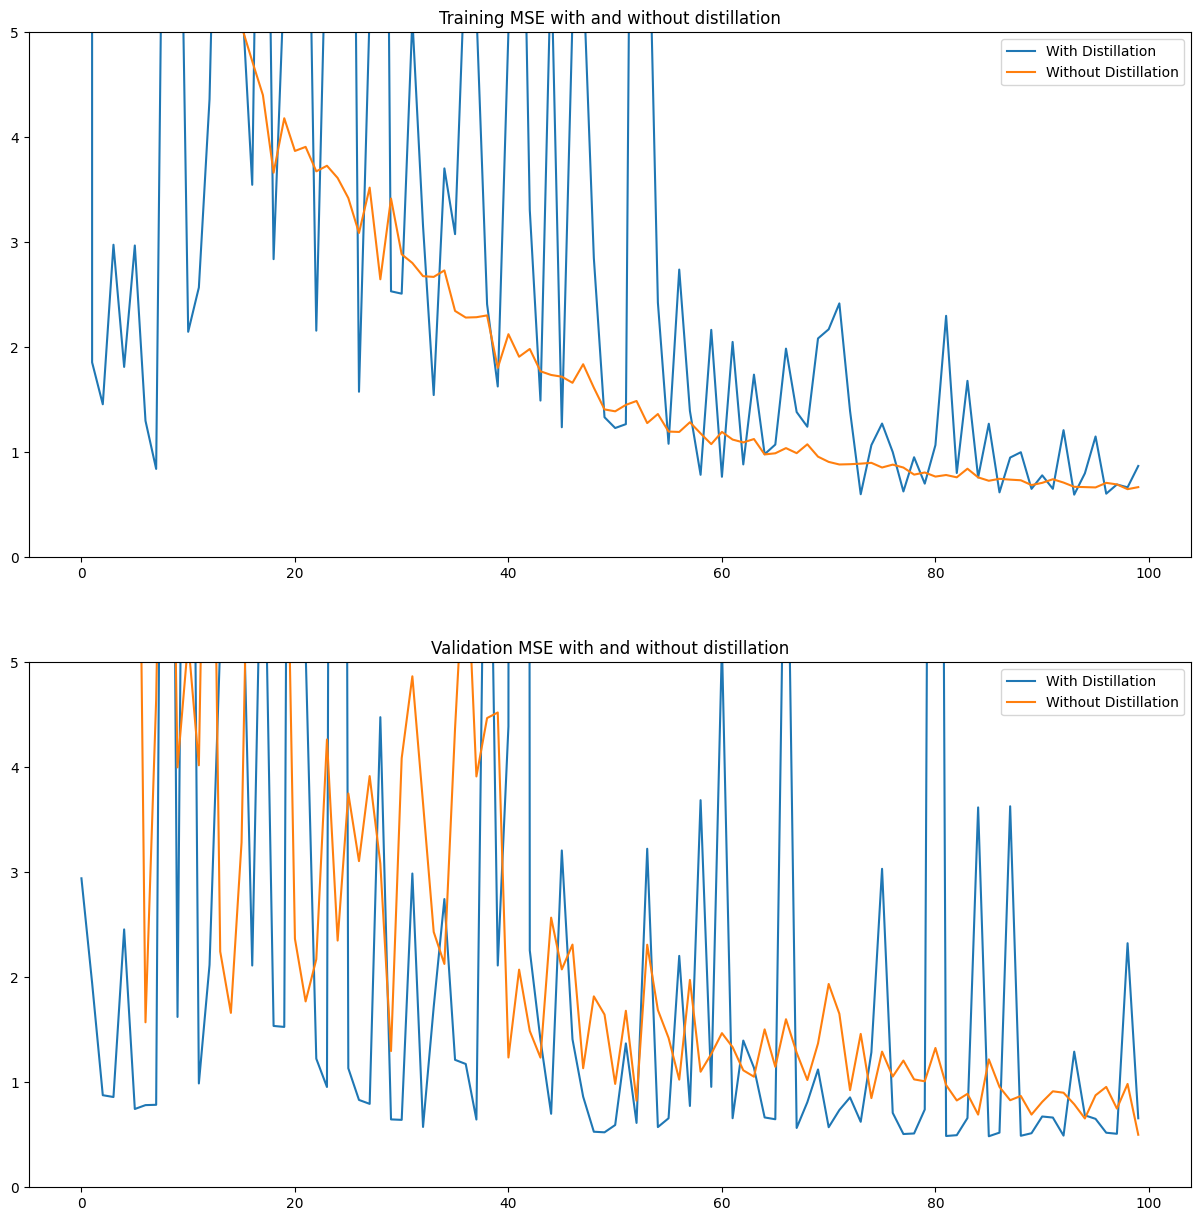

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.5219 +- 0.1648
Validation mse without disstillation 0.5172 +- 0.0372


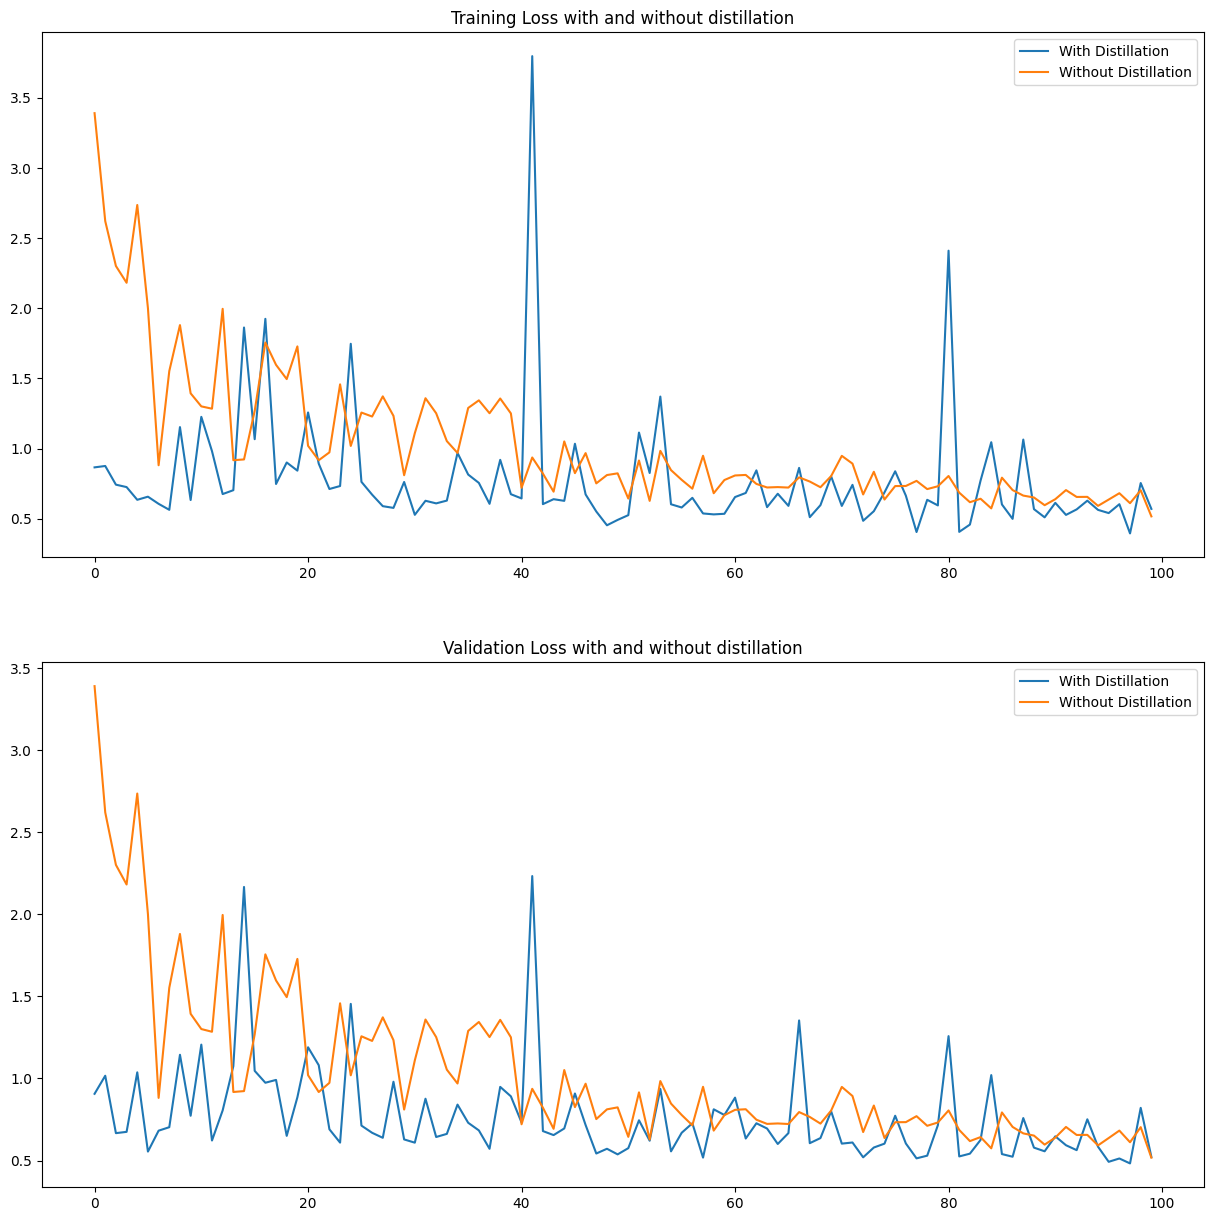

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [11]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 2s 2ms/step - mse: 29512.9512 - mae: 39.0877 - mape: 2569.6775 - student_loss: 38.9579 - distillation_loss: 29413.3989
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 2.4557 - mae: 1.0361 - mape: 68.4800 - student_loss: 1.0347 - distillation_loss: 2.0623
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 4.2050 - mae: 1.1136 - mape: 74.7800 - student_loss: 1.1131 - distillation_loss: 3.8346
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 1.4499 - mae: 0.9003 - mape: 59.1880 - student_loss: 0.8983 - distillation_loss: 1.0290
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 14.0514 - mae: 1.6225 - mape: 106.9330 - student_loss: 1.6198 - distillation_loss: 13.6171
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 0.8733 - mae: 0.6919 - mape: 44.7194 - student_loss: 0.6920 - distillation_loss: 0.4639
Epoch 7/100
4

492/492 [==============================] - 1s 2ms/step - mse: 6.4025 - mae: 1.0408 - mape: 69.0128 - student_loss: 1.0399 - distillation_loss: 6.0113
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 18.7773 - mae: 1.6417 - mape: 108.4073 - student_loss: 1.6437 - distillation_loss: 18.3581
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 1.8889 - mae: 0.8161 - mape: 53.7654 - student_loss: 0.8149 - distillation_loss: 1.4548
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.6952 - mae: 0.6068 - mape: 39.2738 - student_loss: 0.6059 - distillation_loss: 0.2822
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 1.4159 - mae: 0.7078 - mape: 47.0130 - student_loss: 0.7150 - distillation_loss: 1.0428
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 40.3463 - mae: 2.0947 - mape: 136.3639 - student_loss: 2.0898 - distillation_loss: 39.7051
Epoch 57/100
492/492 [=======

492/492 [==============================] - 1s 2ms/step - loss: 4.6896 - mse: 209.0046 - mae: 4.6896 - mape: 310.3503
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 2.5726 - mse: 16.3779 - mae: 2.5726 - mape: 171.3174
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 2.4332 - mse: 13.9244 - mae: 2.4332 - mape: 160.1310
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 2.1599 - mse: 12.3756 - mae: 2.1599 - mape: 142.6651
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 2.3610 - mse: 15.1078 - mae: 2.3610 - mape: 156.1487
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 1.8845 - mse: 9.1695 - mae: 1.8845 - mape: 123.3923
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 2.1760 - mse: 10.5753 - mae: 2.1760 - mape: 143.8582
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 1.8800 - mse: 7.8511 - mae: 1.8800 - mape

492/492 [==============================] - 1s 2ms/step - loss: 0.7013 - mse: 0.9406 - mae: 0.7013 - mape: 44.7064
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7832 - mse: 1.2207 - mae: 0.7832 - mape: 50.1726
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7969 - mse: 1.3103 - mae: 0.7969 - mape: 51.1752
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6948 - mse: 0.9076 - mae: 0.6948 - mape: 44.2325
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7144 - mse: 0.9674 - mae: 0.7144 - mape: 45.4462
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7196 - mse: 1.1044 - mae: 0.7196 - mape: 45.7704
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7664 - mse: 1.2796 - mae: 0.7664 - mape: 48.9731
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7033 - mse: 0.9891 - mae: 0.7033 - mape: 44.66

In [12]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.6567452549934387, 'mae': 0.5997418761253357, 'mape': 36.95670700073242, 'student_loss': 0.6375452280044556}
Test mse without disstillation {'loss': 0.6183237433433533, 'mse': 0.6713912487030029, 'mae': 0.6183237433433533, 'mape': 40.392234802246094}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
